In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 20

import desc.io
from desc.grid import LinearGrid, ConcentricGrid
from desc.objectives import (
    ObjectiveFunction,
    FixBoundaryR,
    FixBoundaryZ,
    FixPressure,
    FixIota,
    FixPsi,
    AspectRatio,
    ForceBalance,
    QuasisymmetryBoozer,
    QuasisymmetryTwoTerm,
    QuasisymmetryTripleProduct,
    RotationalTransform,
    AspectRatio
)
from desc.optimize import Optimizer
from desc.plotting import (
    plot_grid,
    plot_boozer_modes,
    plot_boozer_surface,
    plot_qs_error,
    plot_boundaries,
    plot_boundary,
)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


DESC version 0+untagged.9459.g8c16d30.dirty,using JAX backend, jax version=0.4.28, jaxlib version=0.4.28, dtype=float64
Using device: CPU, with 1.35 GB available memory


In [2]:
# load initial equilibrium
eq_init = desc.io.load("inputs/nfp2_QA.h5")
eq_init = eq_init[-1]

optimizer = Optimizer("proximal-lsq-exact")

# indices of boundary modes we want to optimize
idx_Rcc = eq_init.surface.R_basis.get_idx(M=1, N=2)
idx_Rss = eq_init.surface.R_basis.get_idx(M=-1, N=-2)
idx_Zsc = eq_init.surface.Z_basis.get_idx(M=-1, N=2)
idx_Zcs = eq_init.surface.Z_basis.get_idx(M=1, N=-2)
print("surface.R_basis.modes is an array of [l,m,n] of the surface modes:")
print(eq_init.surface.R_basis.modes[0:10])

# boundary modes to constrain
R_modes = np.delete(eq_init.surface.R_basis.modes, [idx_Rcc, idx_Rss], axis=0)
Z_modes = np.delete(eq_init.surface.Z_basis.modes, [idx_Zsc, idx_Zcs], axis=0)

eq_qs_T = eq_init.copy()  # make a copy of the original one
# constraints
constraints = (
    ForceBalance(eq=eq_qs_T),  # enforce JxB-grad(p)=0 during optimization
    FixBoundaryR(eq=eq_qs_T, modes=R_modes),  # fix specified R boundary modes
    FixBoundaryZ(eq=eq_qs_T, modes=Z_modes),  # fix specified Z boundary modes
    FixPressure(eq=eq_qs_T),  # fix pressure profile
    FixPsi(eq=eq_qs_T),  # fix total toroidal magnetic flux
)


surface.R_basis.modes is an array of [l,m,n] of the surface modes:
[[ 0 -4 -5]
 [ 0 -3 -5]
 [ 0 -2 -5]
 [ 0 -1 -5]
 [ 0 -4 -4]
 [ 0 -3 -4]
 [ 0 -2 -4]
 [ 0 -1 -4]
 [ 0 -4 -3]
 [ 0 -3 -3]]


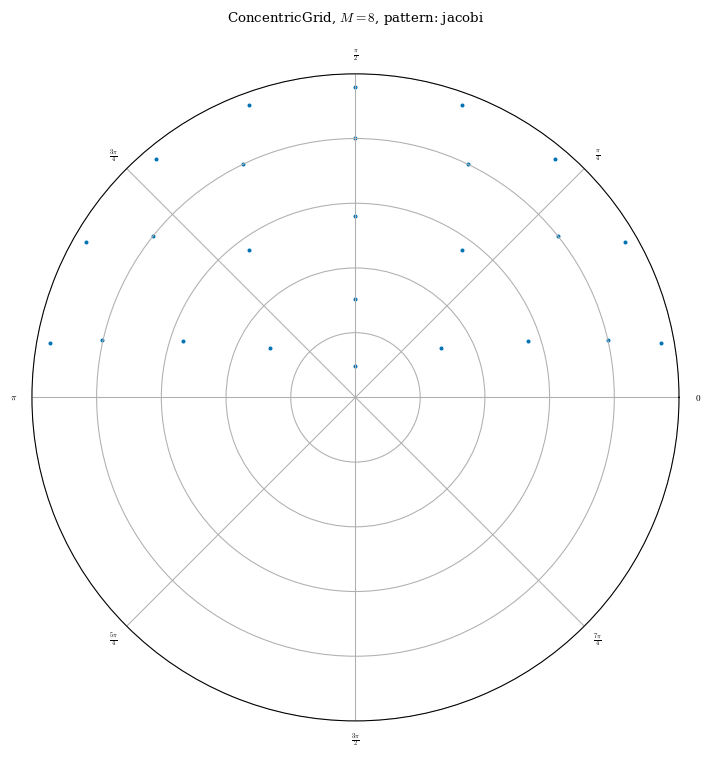

In [3]:
# objective
grid_vol = ConcentricGrid(
    L=eq_init.L_grid,
    M=eq_init.M_grid,
    N=eq_init.N_grid,
    NFP=eq_init.NFP,
    sym=eq_init.sym,
)
plot_grid(grid_vol, figsize=(8, 8))

objective_fT = ObjectiveFunction((AspectRatio(eq=eq_init, target=6, weight=1),RotationalTransform(eq=eq_init, target=0.42, weight=1)))


In [4]:
eq_qs_T, result_T = eq_qs_T.optimize(
    objective=objective_fT,
    constraints=constraints,
    optimizer=optimizer,
    ftol=5e-2,  # stopping tolerance on the function value
    xtol=1e-6,  # stopping tolerance on the step size
    gtol=1e-6,  # stopping tolerance on the gradient
    maxiter=50,  # maximum number of iterations
    options={
        "perturb_options": {"order": 2, "verbose": 0},  # use 2nd-order perturbations
        "solve_options": {
            "ftol": 5e-3,
            "xtol": 1e-6,
            "gtol": 1e-6,
            "verbose": 0,
        },  # for equilibrium subproblem
    },
    copy=False,  # copy=False we will overwrite the eq_qs_T object with the optimized result
    verbose=3,
)

Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 823 ms
Building objective: rotational transform
Precomputing transforms
Timer: Precomputing transforms = 253 ms
Timer: Objective build = 1.20 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 890 ms
Timer: Objective build = 3.31 sec


TypeError: slice slice_sizes must be greater than or equal to zero, got slice_sizes of (363, -363).

In [ ]:
plot_boozer_surface(eq_qs_T);  # |B| contours at rho=1 surface